## Semester 1 Project Submission

Please fill out:
* Student name: 
* Instructor name: 


In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [2]:
### Relevant Imports ###
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile

%matplotlib inline

# Business Understanding

### Business Understanding

Computing Vision (a made-up company for the purposes of this project) sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t have much background in creating movies. You are charged with exploring what types of films are currently doing the best at the box office using different samples of available data. You then will translate those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.

### Business Metrics

Our recommendations for this company will be based off of the Gross Margin which is portrayed as a percentage. The higher this percentage is the more the company is retaining for every dollar that is invested in the movie and as such is seeing a higher return on their investment.

$Gross Margin = \frac{Gross Revenue - Costs}{Gross Revenue} x 100$

This is an important metric, especially for a company about to enter an industry they have no presence in because it will help show how far their money goes to create profit. The higher this percentage the better the business will be doing because it is an indicator that retains more on each dollar of sales to its costs. This metric also allows us to take a standardized approach to comparing movies and their success. 

We want to investigate what a "Good Movie" i.e. a movie with a high Gross Margin is doing and try to emulate that. Thus we will explore the budget size, what directors are involved in those high margin films, and also what genres see the highest margin

# Data Understanding
### Opening all zipped files and databases

We began our exploring our data by unzipping the SQLite database as well as reading in all of out csv/tsv files into pandas data frames to get a better idea of how we can approach cleaning the data

In [3]:
# open an sqlite connection

conn = sqlite3.connect("zippedData/im.db")
cur = conn.cursor()

In [4]:
# Pull all of the tables in the database
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [5]:
# query the notable tables movie_basics
q1 = """
SELECT *
FROM movie_basics
LIMIT 5;
"""
pd.read_sql(q1, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [6]:
# query the notable tables movie_ratings
q2 = """
SELECT *
FROM movie_ratings
LIMIT 5;
"""
pd.read_sql(q2, conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


### Database information

These two database tables share a "movie_id" column, thus we can join on this key and take a look at movie information including name, release year, and genre as well as the average rating with the number of votes. We want to find a good balance of average rating as well as number of ratings since a small number of really high ratings could skew the interpretation of what a "good" movie is.

### CSV and TSV file information

Read in all of the tsv and csv files in the proper formatting ensuring headers and proper indexing for the ones which require it as well as proper encoding for the tsv files

In [7]:
movie_info = pd.read_csv("zippedData/rt.movie_info.tsv",header = 0, sep = '\t')    

reviews = pd.read_csv("zippedData/rt.reviews.tsv", header = 0, sep = '\t', encoding= 'unicode_escape')

tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv", header = 0)    

movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", header = 0)

movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv", header = 0)

#### Movie Info Dataframe

This dataframe contains general information regarding the movies including rating, director, release date for theaters and DVD as well as the currency, box office, runtime and studio. There is a unique id column which we will not use as an index because it could be useful for combining data frames or doing different lookups

We may consider dropping currency, box office, and studio due to there being many missing values

Most columns are missing values and as such we will have to fill or deal with those missing values accordingly, this dataframe is related to the reviews data frame by the id column which relates to a unique id for each movie

In [8]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [9]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


#### Review Dataframe

The most important information from this dataframe will be the id which cooresponds to the movie that they are reviewing and the rating that they give it. We are missing about more than 10,000 ratings which is a considerable amount to discard, so we could fill these with the average value of the rating for the movie that they are reviewing. In order to make thge rating a useful variable we would have to apply a function to transform it from a string into a float rating value

A more advanced approach would be to conduct sentiment analysis and apply weights to the most common keywords found in a review at each score level and develop a heuristic to apply a score to the missing values based on the review that they left discarding all review entries without an actual review.

This data frame has a relation to the movie_info data frame since bothg come from rotten tomatoes. The id relates to the movie that each critic leaves a review for. 

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [11]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


#### The Movie DB Dataframe

This dataframe is not missing any values. It has information about genre ids and contains a unique id column along with the movie name, how many votes it received, and what the average vote value was. Vote seems to be this specific sites way of ranking the movies. 

In [12]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [13]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [14]:
# Create a dictionary to relate the genre id's to the genre found on the movie DB website at 
# this customer support url: https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
tmbd_genres = {28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance", 878: "Science Fiction", 10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"}

#### Moview Budgets Data Frame

This data frame is also not missing any values, it contains an ID for each movie, the title, production budget, how much the movie grossed domestically and how much it grossed worldwide

We will be transforming this data by making the budget and gross column integers as well as adding additional columns for profit and Gross Margin to help us in later analysis

In [15]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [16]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


#### Movie Gross Data Frame

This data frame is missing a lot of foreign gross values which could potentially be filled in by taking the difference from the budgets df ww_gross - domestic_gross, otherwise we will throw out those values because we can not estimate them.

An alternative that we will not explore is scraping the web with the name of the movie and pulling in the foreign gross numbers. We are missing a few domestic gross numbers which can be thrown away since there are not many of them or we can use the movie budgets dataframe again to fill those in. 

We most likely will not use this data frame because the movie_budgets dataframe offer the same information and a bit more that is helpful to our analysis

In [17]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [18]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


# Data Preparation

### Data Cleaning for movie_budgets DataFrame

The money_clean function we created removes the '$' and comma symbols from the input string. We used this function to clean the production_budget, domestic_gross, and worldwide_gross columns.

In [19]:
# This is the column of budgets which we want to investigate - notice formatting problems
prod_budget = movie_budgets["production_budget"]
prod_budget

0       $425,000,000
1       $410,600,000
2       $350,000,000
3       $330,600,000
4       $317,000,000
            ...     
5777          $7,000
5778          $6,000
5779          $5,000
5780          $1,400
5781          $1,100
Name: production_budget, Length: 5782, dtype: object

In [20]:
def money_clean(s):
    ''' 
    Takes in a string s, removes first character ($) and
    all commas return the value cast as an int
    '''
    s = s[1:]
    s = s.replace(",", "")
    return int(s)

# apply the method to the pandas series of budget values
prod_budget = prod_budget.apply(money_clean)

In [21]:
# Set this cleaned series to the budget column in the data frame
movie_budgets["production_budget"] = prod_budget

# apply the function to the other money columns
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].apply(money_clean)
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].apply(money_clean)

# Calculate new values for foreign gross 
movie_budgets["foreign_gross"] = movie_budgets["worldwide_gross"] - movie_budgets["domestic_gross"]

# calculate the profit by taking gross minus budget (Revenue - cost)
movie_budgets["domestic_profit"] = movie_budgets["domestic_gross"] - movie_budgets["production_budget"]
movie_budgets["foreign_profit"] = movie_budgets["foreign_gross"] - movie_budgets["production_budget"]
movie_budgets["total_profit"] = movie_budgets["worldwide_gross"] - movie_budgets["production_budget"]

In [22]:
# create new month and year columns for later analysis
rel_date = movie_budgets["release_date"].str.strip()

month = rel_date.apply(lambda x : x[:3])
year = rel_date.apply(lambda x : x[-4:])

movie_budgets["month"] = month
movie_budgets["year"] = year

In [23]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2015837654,335507625,1590837654,2351345279,Dec,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,804600000,-169536125,394000000,635063875,May,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,107000000,-307237650,-243000000,-200237650,Jun,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,944008095,128405868,613408095,1072413963,May,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,696540365,303181382,379540365,999721747,Dec,2017


# Exploratory Data Analysis and Visualization

## Mason Batchelor

##### Mason works only in this section and makes No changes to any other



### Analyzing Movie Budgets

Within the movie budgets data frame we created new column to represent the profit, month, and year for each of the entries. We are going to look at the relationship between many of these variables below. 

Adding in a Gross Margin column is essential given this is the metric we are most interested in. We will use this first to analyze the differnce in budgets, and recommend whether the company should target a large or small budget film. We are going to be taking a sample of 100 movies from the movie_budgets data frame to help with our analysis and visualizations. 

Additional Assumptions:
- only consider movies with a Gross value (worldwide, domestic, and foreign) greater than zero because you cannot calculate Gross Margin with 0 gross revenue
- randome samples from this data frame are representative of the population, and will be used in a independent two sample ttest
- only consider movies with gross margin > -100 to remove outliers and aid in visualizations

In [24]:
# Create the Gross Margin column in a new dataframe called budgets
budgets =  movie_budgets.copy()
# only use movies that gross > 0
budgets = budgets.loc[budgets['worldwide_gross'] > 0]
# calculate gross Margin
budgets['gross_margin_ww'] = (budgets['worldwide_gross'] - 
                              budgets['production_budget']) / budgets['worldwide_gross'] * 100

# only care about values with Gross Margin > 0
# budgets_ww = budgets_ww.loc[budgets_ww['gross_margin'] > 0]

In [25]:
# take a random sample of size 100
sample = budgets.loc[budgets['gross_margin_ww'] > -100].sample(n=100)

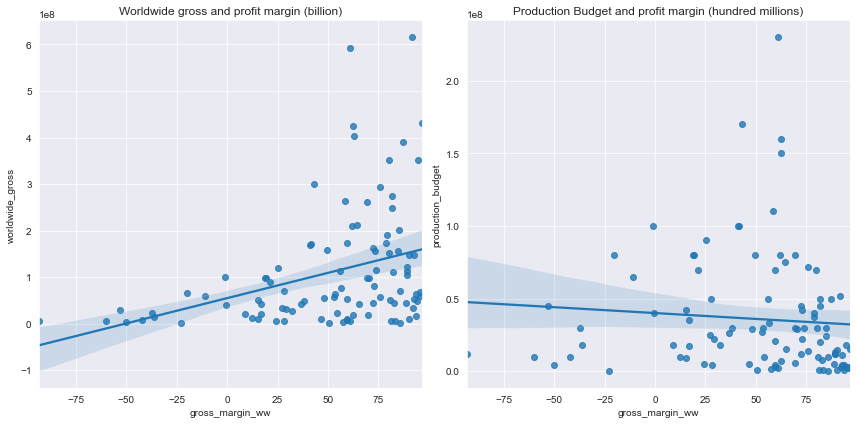

In [26]:
# This plot is visualizing the WORLDWIDE profit margin calculated using worldwide gross
sns.set_style("darkgrid")

fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols = 2)
sns.regplot(data = sample, x = "gross_margin_ww" , y = "worldwide_gross", ax=ax1);
sns.regplot(data = sample, x = "gross_margin_ww" , y = "production_budget", ax=ax2);

ax1.set_title("Worldwide gross and profit margin (billion)")
ax2.set_title("Production Budget and profit margin (hundred millions)")
plt.tight_layout();

For high budget movies make sure to keep in mind the international audience because as the budget increases profits domestically trend downward however on the international audience profits trend upwards. If you are focusing on a low budget movie to enter into the movie industry then the focus should be domestic because profits tend to be higher comapred to international movies

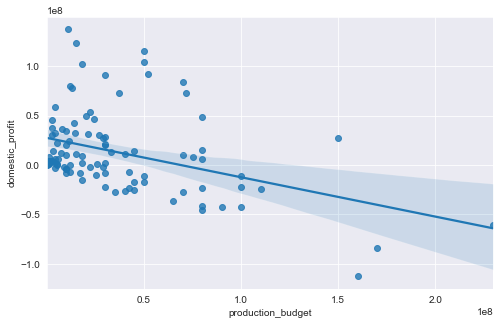

In [40]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample, x = "production_budget" , y = "domestic_profit", ax=ax);

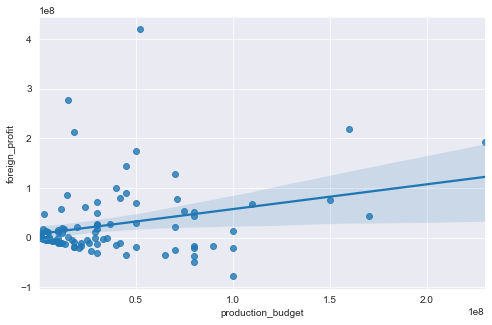

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample, x = "production_budget" , y = "foreign_profit", ax=ax);

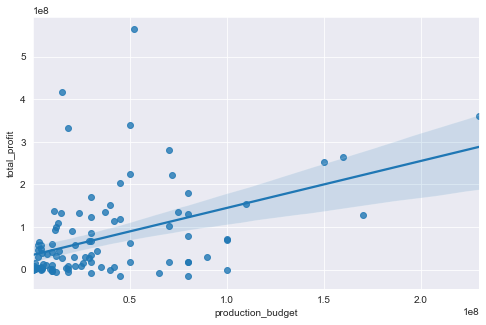

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample, x = "production_budget" , y = "total_profit", ax=ax);

In [31]:
month = pd.to_datetime(sample['release_date']).dt.month
sample['month_index'] = month

''

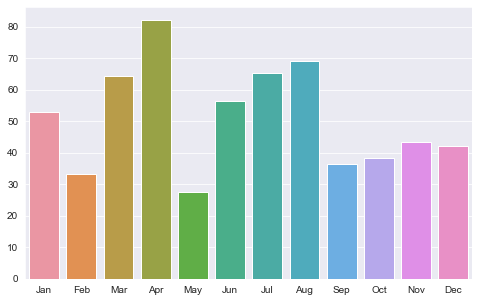

In [91]:
fig, ax = plt.subplots(figsize=(8,5))
# get the month values and aggregate gross margin to plot
x_values = sample.sort_values('month_index')['month'].unique()
agg_margin = sample.groupby('month_index')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values, errwidth=0)
ax.set_ylabel("");

In [33]:
dates = pd.to_datetime(movie_budgets['release_date'])
months = dates.dt.month
movie_budgets['month_index'] = months

In [56]:
sample.loc[sample['month_index'] == 7]['foreign_profit'].mean()

90628462.1

These graphs do not have aggregate values and are not being used in the current analysis

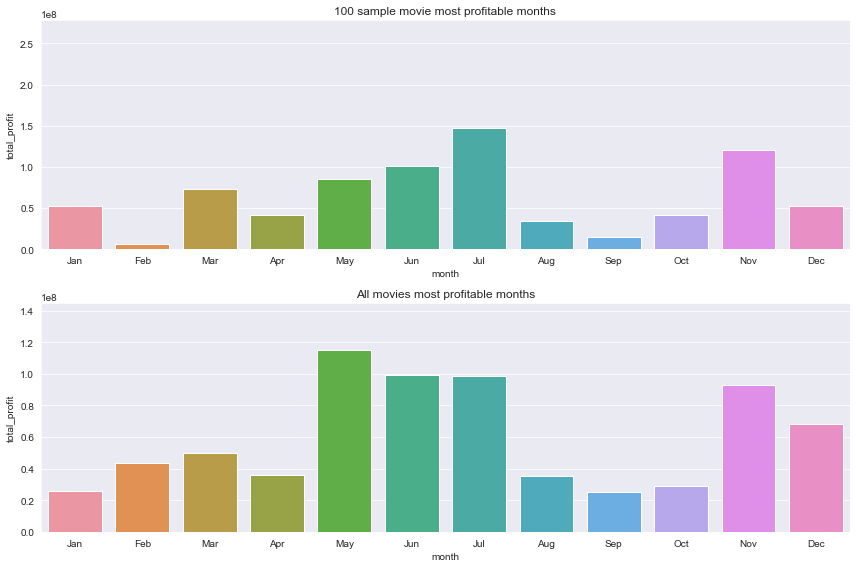

In [47]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,8), nrows = 2)
sns.barplot(data = sample.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax = ax1, 
            errwidth=0)
sns.barplot(data = movie_budgets.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax=ax2, 
            errwidth=0)

ax1.set_title("100 sample movie most profitable months")
ax2.set_title("All movies most profitable months")
plt.tight_layout()

## Maninder Bawa

##### Maninder works only in this section and makes No changes to any other


## Jessica Pasquesi

##### Jessica works only in this section and makes No changes to any other


## Vijeet Yarlagadda

##### Vijeet works only in this section and makes No changes to any other
